In [1]:
# !pip install pyecharts
# !pip install selenium
import numpy as np 
import matplotlib.pyplot as plt 
#!pip install yfinance
import yfinance as yf # https://pypi.org/project/yfinance/
import math
import random
import seaborn as sns
import datetime
import pandas as pd
from pyecharts.charts import Bar, Line
from pyecharts import options as opts

In [41]:
# get data by ticker-name, start-time & end-time
def get_df_data(ticker_name="AAPL", start_time="2022-01-01", end_time="2022-10-09"):
    df_data = yf.download(tickers=ticker_name, start=start_time, end=end_time) 
    df_data = df_data[ ["Open", "High", "Low", "Close", "Volume"] ]
    df_data['previous_Close'] = df_data['Close'].shift(1)
    df_data['daily_return'] = (df_data['Close']-df_data['previous_Close'])/df_data['previous_Close']
    return df_data

def draw_2lines(x, y1, tn1, y2, tn2, ls1=50, le1=160, ls2=50, le2=160):
    data_1 = y1 #np.sin(x)
    data_2 = y2 #np.cos(x)
    # Create Plot
    fig, ax1 = plt.subplots(figsize=(25, 10)) 
    ax1.set_xlabel('Time range') 
    ax1.set_ylabel(tn1, color = 'red') 
    ax1.plot(x, data_1, color = 'red', label=tn1) 
    ax1.tick_params(axis ='y', labelcolor = 'red') 
    ax1.set_ylim(ls1, le1)
    ax2 = ax1.twinx() 
    ax2.set_ylabel(tn2, color = 'blue') 
    ax2.plot(x, data_2, color = 'blue', label=tn2) 
    ax2.tick_params(axis ='y', labelcolor = 'blue') 
    ax2.set_ylim(ls2, le2)
    # show the graph
    plt.legend()
    plt.show()
    return 

"""
# data visualization
ls1=ls2=60 
le1=le2=100

y1, y2 = y1_open, y2_open
draw_2lines(x, y1, tn1, y2, tn2, ls1, le1, ls2, le2)
"""

def time_point_dic(time_list, point_close):
    dic = {}
    i = 0
    while i<len(time_list):
        dic[time_list[i]] = point_close[i]
        i += 1
    return dic



def bin_analysis(point_list, low_level=0.0, high_level=3.0, level_width=0.1):
    # low_level, high_level, level_width, 
    k_num = round((high_level-low_level)/level_width) + 1
    N = len(point_list)
    fre_dic = {}
    for k in range(k_num):
        fre_dic[round(k*level_width, 1)] = 0

    for v in point_list:
        k = round(v/level_width) * level_width
        if k>high_level:
            k = high_level
        k = round(k, 1)
        fre_dic[k] += 1
    
    x_list, y_list = [], []
    cumulative = 0
    for k in range(k_num):
        k = round(k*level_width, 1)
        cumulative = cumulative + fre_dic[k]
        r = round(cumulative/N*100, 2)
        #print( k, "\t", cumulative, "\t", r, "%" )
        x_list.append( k )
        y_list.append( r )
    return x_list, y_list

def find_previous_businessday(i, x, y):
    counter = i
    t = x[counter]
    p = y[counter]
    while p<0 and counter>0:
        t = x[counter]
        p = y[counter]
        counter = counter - 1
    #if counter!=i:
        #print( "\t reference stock in holiday \t", x[i], y[i], " -> ", t, p )
    return t, p

def find_next_businessday(i, j, x, y):
    counter = i
    point_list = []
    while counter<=j and counter<len(x):
        point_list.append( y[counter] )
        counter += 1
    if len(point_list)==0:
        return [0]
    return point_list

# 
def back_test(signal, in_days, x, 
              y1_open, y1_close, y1_low, y1_high, 
              y2_open, y2_close, y2_low, y2_high):
    other_info = []
    profit_list = []
    for i in range(0, len(x)-1):
            # reference stock info
        reference_t, reference_p = find_previous_businessday(i, x, y1_close)
            # target stock info
        target_t = x[i+1]
        target_open = y2_open[i+1]
        target_close = y2_close[i+1]
        target_low = y2_low[i+1]
        target_high = y2_high[i+1]
        if target_open<0:
            #print( target_t, "\t target stock in holiday" )
            continue
        #print( target_t, target_open, target_close, target_low, target_high, "\t", reference_t, reference_p )
            # possible profit
        if target_low<reference_p-signal:
            buy_point = min(target_open, reference_p-2)
            j = i+in_days
            high_list = find_next_businessday(i+2, j, x, y2_high)
            close_list = find_next_businessday(i+2, j, x, y2_close)
            sell_point = max( target_close, max(high_list) )
            profit = round( sell_point-buy_point, 2 )
            if profit<1:
                profit = round( close_list[-1]-buy_point, 2 )
            profit_list.append( profit )
            other_info.append( [reference_t, reference_p, target_t, target_open, target_close, target_low, target_high, buy_point, sell_point, profit] )
    return profit_list, other_info

def get_list(from_num=1.5, to_num=3.0, step_num=0.1):
    tmp_list = []
    num = from_num
    while num<=to_num:
        num = round(num, 1)
        tmp_list.append( num )
        num += step_num
    return tmp_list

def profit_analysis(profit_list, from_num=1.0, to_num=3.0, step_num=0.1):
    info = []
    N = len(profit_list)
    for profit_per_share in get_list(from_num, to_num, step_num):
        counter = 0
        for v in profit_list:
            if v >= profit_per_share:
                counter += 1
        r = round(counter / N * 100, 2)
        info.append( (profit_per_share, N, counter, r) )
    return info

#
# data_info, 
    # signal
        # in_days
            # profit_per_share, ratio
def data_by_signal(data_info, ll=2.0, hl=11):
    data, col_names = [], []
    for signal in range(hl):
        signal = ll + 0.1*signal
        signal = round(signal, 1)
        #
        info = data_info[signal]        
        for days in sorted( list(info.keys()) ):
            it = info[days]
            N = len(it)
            tmp_n = ["signal", "days"]
            tmp_v = [signal, days]   
            i = 0
            while i<N:
                tmp_n.append( "profit_" + str(it[i][0]) )
                tmp_v.append( it[i][1] )            
                i = i + 1
            data.append(tmp_v)
            col_names.append( tmp_n )
    col_names = col_names[0]
    #print(col_names)
    df = pd.DataFrame(data, columns=col_names)
    return df

def dict_lists(dic):
    x = sorted( list(dic.keys()) )
    y = []
    for t in x:
        y.append( dic[t] )
    return x, y

def cumulative_return(tmp_list):
    cr_list = []
    r = 1
    for v in tmp_list:
        r = r*(1+v)
        cr_list.append( round(r*100, 2) )
        #print(r)
    return cr_list

In [101]:
# 
def data_union(dic1, dic2):
    # add in complement time values
    time1 = list(dic1.keys())
    time2 = list(dic2.keys())
    time_union = sorted(list(set(time1+time2)))
    for t in time_union:
        if t not in dic1:
            dic1[t] = 0
        if t not in dic2:
            dic2[t] = 0
    return time_union

st, et = "2022-10-27", "2023-01-31"
print("time range:\t", st, "-", et)

df = pd.DataFrame()

# ('BABA', '9988.HK', '2022-11-01')
# ('BIDU', '9888.HK', '2022-10-25')
# ('NTES', '9999.HK', '2022-10-26') 
# ('JD', '9618.HK', '2022-10-24')
# ('MPNGY', '3690.HK', '2022-10-24')
# ('TME', '0700.HK', '2022-10-25')
for it in [('MPNGY', '3690.HK', '2022-10-24')]:
    tn1, tn2, st = it

    #tn1 = "BABA" # BABA, BIDU, JD, MPNGY, TME, NTES
    df_data1 = get_df_data(ticker_name=tn1, start_time=st, end_time=et)
    print("stock:\t", tn1, "\t", len(df_data1))

    #tn2 = "9988.HK" # 9988.HK, 9888.HK, 9618.HK, 3690.HK, 0700.HK, 9999.HK
    df_data2 = get_df_data(ticker_name=tn2, start_time=st, end_time=et)
    print("stock:\t", tn2, "\t", len(df_data2))

    # dict-type: key -> datetime, value -> point
    dic1_return = time_point_dic(list(df_data1.index), list(df_data1['daily_return']))
    dic2_return = time_point_dic(list(df_data2.index), list(df_data2['daily_return']))
    print( "2 stocks:\t")
    print( "\t", len(dic1_return) )
    print( "\t", len(dic2_return) )

    # data union, stock 1 may have some business-day when stock 2 in holiday, and vice versa
    time_union = data_union(dic1_return, dic2_return)
    print( "2 stocks:\t")
    print( "\t", len(dic1_return) )
    print( "\t", len(dic2_return) )

    #
    start_index, end_index = 1, 261
    x1, y1 = dict_lists(dic1_return)
    x1, y1 = x1[start_index : ], y1[start_index : ]
    cr_list1 = cumulative_return(y1)

    x2, y2 = dict_lists(dic2_return)
    x2, y2 = x2[start_index : ], y2[start_index : ]
    cr_list2 = cumulative_return(y2)
    assert len(x1)==len(x2)==len(y1)==len(y2)
    print( len(cr_list1), len(cr_list2) )

    """
    plt.subplots(figsize=(20, 6))
    plt.plot(x1[start_index : end_index], cr_list1[start_index : end_index], label="daily return " + str(tn1))
    plt.plot(x2[start_index : end_index], cr_list2[start_index : end_index], label="daily return " + str(tn2))
    plt.legend()
    plt.show()  # display
    """
    df.index = x1
    df[tn1] = cr_list1
    df[tn2] = cr_list2
#
MA = 3
tns = list(df.columns)
for col in tns:
    df[col+"_MA"] = df[col].rolling(MA).mean()
    df[col+"_MA"] = df[col+"_MA"].round(decimals = 2)
df

line_returns = (
    Line(init_opts=opts.InitOpts(width="1800px", height="960px"))      
    .set_global_opts(title_opts=opts.TitleOpts(title="stocks comparison: cumulative returns"), 
                     tooltip_opts=opts.TooltipOpts(trigger="axis"),
                    yaxis_opts=opts.AxisOpts(name='returns',splitline_opts=opts.SplitLineOpts(is_show=True),min_=80))# , subtitle="商店A中六樣商品數"
)

line_returns.add_xaxis( list(df.index)[MA:] )

tns = list(df.columns)
for col in tns:
    line_returns.add_yaxis(col+"", list(df[col])[MA:] )

line_returns.render("lines_returns01.html")

time range:	 2022-10-27 - 2023-01-31
[*********************100%***********************]  1 of 1 completed
stock:	 MPNGY 	 52
[*********************100%***********************]  1 of 1 completed
stock:	 3690.HK 	 53
2 stocks:	
	 52
	 53
2 stocks:	
	 54
	 54
53 53


'C:\\Users\\Admin\\lines_returns01.html'

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


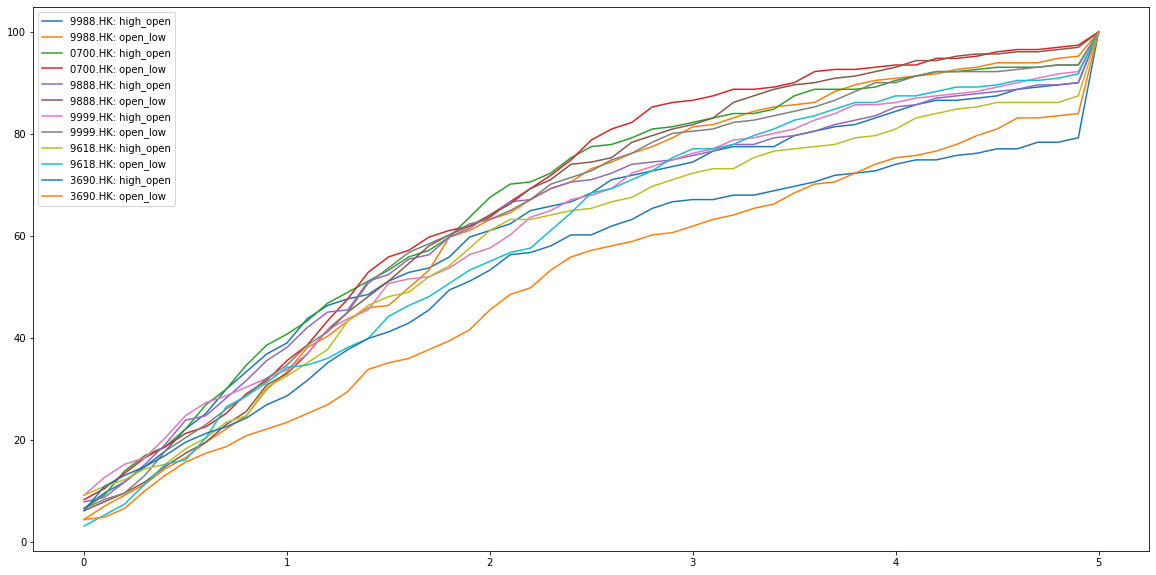

'C:\\Users\\Admin\\lines_HO_OL01.html'

In [96]:
###
def get_reference_stock(tn, st, et):
    df_data = get_df_data(ticker_name=tn, start_time=st, end_time=et)
    return df_data

# 
def data_union(dic1, dic2):
    # add in complement time values
    time1 = list(dic1.keys())
    time2 = list(dic2.keys())
    time_union = sorted(list(set(time1+time2)))
    for t in time_union:
        if t not in dic1:
            dic1[t] = -1
        if t not in dic2:
            dic2[t] = -1
    return time_union

def filter_by_time(df_data, filter_time):
    time_list = list(df_data.index)
    time_set = set(filter_time)
    tmp_list = []
    for t in time_list:
        if t in time_set:
            tmp_list.append( True )
        else:
            tmp_list.append( False )
    return df_data[tmp_list]

plt.subplots(figsize=(20, 10))
line_returns = (
    Line(init_opts=opts.InitOpts(width="1800px", height="960px"))      
    .set_global_opts(title_opts=opts.TitleOpts(title="stocks comparison: HO OL"), 
                     tooltip_opts=opts.TooltipOpts(trigger="axis"),
                    yaxis_opts=opts.AxisOpts(name='returns',splitline_opts=opts.SplitLineOpts(is_show=True),min_=0))# , subtitle="商店A中六樣商品數"
)



st, et = "2022-01-31", "2023-01-31"
tmp_tn = "0700.HK"

flag1 = True

for tmp_tn in ["9988.HK", "0700.HK", "9888.HK", "9999.HK", "9618.HK", "3690.HK"]: # 
    df_data_tmp = get_df_data(ticker_name=tmp_tn, start_time=st, end_time=et)
    df_data_tmp['high_open'] = (df_data_tmp['High']-df_data_tmp['Open'])/df_data_tmp['Open']*100
    df_data_tmp['open_low'] = (df_data_tmp['Open']-df_data_tmp['Low'])/df_data_tmp['Open']*100
    df_data_tmp
    
    ###
    col_name = 'high_open'
    x_list, y_list = bin_analysis( list(df_data_tmp[col_name]), low_level=0.0, high_level=5.0, level_width=0.1 )
    plt.plot(x_list, y_list, label=tmp_tn+": "+col_name)    
    
    tmp_list = []
    for xv in x_list:
        tmp_list.append( str(round(xv, 1)) )
    if flag1:
        line_returns.add_xaxis( tmp_list ) #list(range(len(y_list)))
        flag1 = False    
    line_returns.add_yaxis(col_name+" "+tmp_tn, y_list )
    
    ###
    col_name = 'open_low'
    x_list, y_list = bin_analysis( list(df_data_tmp[col_name]), low_level=0.0, high_level=5.0, level_width=0.1 )
    plt.plot(x_list, y_list, label=tmp_tn+": "+col_name)
    
    tmp_list = []
    for xv in x_list:
        tmp_list.append( str(round(xv, 1)) )
    if flag1:
        line_returns.add_xaxis( tmp_list ) #list(range(len(y_list)))
        flag1 = False    
    line_returns.add_yaxis(col_name+" "+tmp_tn, y_list )
    
    ###
    """df_data_ref = get_reference_stock("BABA", st, et)
    
    dic1_open = time_point_dic(list(df_data_tmp.index), list(df_data_tmp['Open']))
    dic1_low = time_point_dic(list(df_data_tmp.index), list(df_data_tmp['Low']))
    
    dic2_close = time_point_dic(list(df_data_ref.index), list(df_data_ref['Close']))
    
    time_union = data_union(dic1_open, dic2_close)
    time_union = data_union(dic1_low, dic2_close)
    
    filter_time = []
    i = 1
    while i < len(time_union):
        pt = time_union[i-1]
        ref_close_point = dic2_close[pt]
        ct = time_union[i]
        tar_open_point = dic1_open[ct]
        tar_low_point = dic1_low[ct]
        target_point = tar_open_point
        if ref_close_point-target_point>2.5 and target_point>0:
            #print( pt, round(ref_close_point, 2), "\t", ct, round(tar_open_point, 2) )
            filter_time.append( ct )
        i += 1
    df_data_update = filter_by_time(df_data_tmp, filter_time)
    print( len(df_data_tmp), len(df_data_update) )
    
    ### 
    col_name = 'high_open'
    x_list, y_list = bin_analysis( list(df_data_update[col_name]), low_level=0.0, high_level=5.0, level_width=0.1 )
    plt.plot(x_list, y_list, label=tmp_tn+"_update: "+col_name)
    line_returns.add_yaxis(col_name+" "+tmp_tn+"_update", y_list )
    ###
    col_name = 'open_low'
    x_list, y_list = bin_analysis( list(df_data_update[col_name]), low_level=0.0, high_level=5.0, level_width=0.1 )
    plt.plot(x_list, y_list, label=tmp_tn+"_update: "+col_name)
    line_returns.add_yaxis(col_name+" "+tmp_tn+"_update", y_list )"""

plt.legend()
plt.show()  # display

line_returns.render("lines_HO_OL01.html")

In [98]:
df_data_tmp = get_df_data(ticker_name="3690.HK", start_time=st, end_time=et)
df_data_tmp

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume,previous_Close,daily_return
Date,,,,,,,
2022-10-24,135.000000,137.800003,119.099998,120.599998,87427196,NaN,NaN
2022-10-25,120.900002,127.699997,112.800003,123.500000,78266339,120.599998,0.024046
2022-10-26,121.699997,134.600006,121.300003,129.699997,52186329,123.500000,0.050202
2022-10-27,138.399994,139.199997,131.100006,131.800003,41077734,129.699997,0.016191
2022-10-28,131.500000,131.600006,120.199997,121.800003,45546979,131.800003,-0.075873
2022-10-31,122.000000,130.800003,118.800003,124.800003,41381680,121.800003,0.024631
2022-11-01,128.000000,145.000000,127.599998,139.600006,63316429,124.800003,0.118590
2022-11-02,139.000000,149.000000,134.699997,146.699997,40243112,139.600006,0.050860
2022-11-03,141.000000,146.000000,138.199997,141.500000,27092886,146.699997,-0.035446
